# Ouray Fishnet

**Author:** Bryce Young

**Date Created:** 2024-08-26  
**Last Modified:**  2024-09-12

**Overview:** I created a fishnet in ArcGIS Pro, which segmented Ouray County into 10km x 10km parcels, clipped to the county boundary. This will help me download the LiDAR from the [Colorado Hazard Mapping website](https://coloradohazardmapping.com/lidarDownload). In this notbook, I will segment the fishnet shapefile into 23 individual shapefiles that will be used as inputs to the website to download areas.

Outside this notebook, I download the zip files from the website and unzip them. I then use this notebook to organize those files. Since each fishnet tile has its own folder of laz tiles from multiple datasets, and there are hundreds of duplicates between all the folders, we need a script to find and copy the files we want and add them to a laz catalog while avoiding duplicates.

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

os.getcwd()

'c:\\Users\\by197116\\Documents\\Projects\\Ouray_ParcelRisk'

<Axes: >

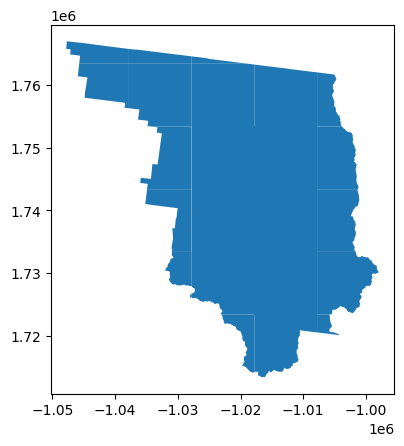

In [3]:
ouray_fishnet = gpd.read_file('E:\_DATA\Boundaries\Colorado_County_Boundaries\Ouray_Fishnet_clipped.shp')
ouray_fishnet.plot()

In [4]:
ouray_fishnet.head()

,Id,geometry
0,0,"POLYGON ((-1017794.464 1714191.472, -1017815.7..."
1,0,"POLYGON ((-1007794.464 1720534.830, -1007808.2..."
2,0,"POLYGON ((-1007794.464 1720534.830, -1007794.4..."
3,0,"MULTIPOLYGON (((-1027794.464 1726732.828, -102..."
4,0,"POLYGON ((-1017794.464 1723377.570, -1023024.0..."


We can see that the 'Id' value is 0 in every row. Since the Id value is arbitrary (i.e. not tied to other values that it must match to), we're going to just populate the column with the index + 1. 

In [5]:
# Populate ID column
ouray_fishnet['Id'] = range(1, len(ouray_fishnet) + 1)

# Preview and ensure proper gdf shape
print(ouray_fishnet.head())
print(ouray_fishnet.shape)

   Id                                           geometry
0   1  POLYGON ((-1017794.464 1714191.472, -1017815.7...
1   2  POLYGON ((-1007794.464 1720534.830, -1007808.2...
2   3  POLYGON ((-1007794.464 1720534.830, -1007794.4...
3   4  MULTIPOLYGON (((-1027794.464 1726732.828, -102...
4   5  POLYGON ((-1017794.464 1723377.570, -1023024.0...
(23, 2)


In [6]:
# Save back to shapefile, overwriting
ouray_fishnet.to_file('E:/_DATA/Boundaries/Colorado_County_Boundaries/Ouray_Fishnet_clipped.shp', index = False)

Now we want to save each polygon and multipolygon as an individual shapefile.

In [ ]:
for i in ouray_fishnet['Id']:
    parcel = ouray_fishnet[ouray_fishnet['Id'] == i].copy()
    file_path = f'E:/_DATA/Boundaries/Colorado_County_Boundaries/Fishnet_Parcels/Ouray/fishnet_{i}.shp'
    parcel.to_file(file_path, index = False)

<Axes: >

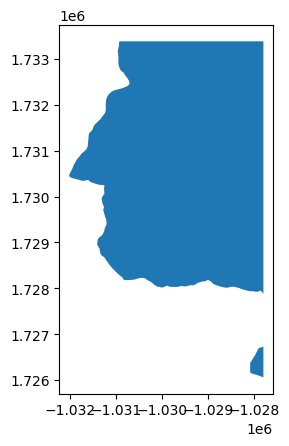

In [13]:
ouray_fishnet[ouray_fishnet['Id'] == 4].plot()

The website actually cannot handle multipolygons, so I will have to handle this. Let's first see how many tiles are multipolygons

In [15]:
multipolygons = ouray_fishnet[ouray_fishnet.geometry.type == 'MultiPolygon']
print(multipolygons)

   Id                                           geometry
3   4  MULTIPOLYGON (((-1027794.464 1726732.828, -102...


Great, it's actually only one, which I plotted above. And that little tiddlywink at the bottom is not important to me, so I'm just going to cut it out.

<Axes: >

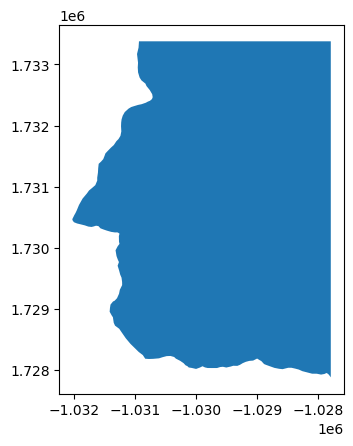

In [17]:
from shapely.geometry import MultiPolygon, Polygon

fishnet_4 = gpd.read_file('E:/_DATA/Boundaries/Colorado_County_Boundaries/Fishnet_Parcels/fishnet_4.shp')

# Function to remove the smallest polygon from a multipolygon
def remove_smallest_polygon(geometry):
    if isinstance(geometry, MultiPolygon):
        # Get a list of the individual polygons using the 'geoms' attribute
        polygons = list(geometry.geoms)
        # Find the smallest polygon by area
        smallest_polygon = min(polygons, key=lambda p: p.area)
        # Create a new MultiPolygon without the smallest one
        polygons.remove(smallest_polygon)

        # If only one polygon remains, return it as a Polygon, not a MultiPolygon
        if len(polygons) == 1:
            return polygons[0]
        else:
            return MultiPolygon(polygons)
        
    return geometry  # Return the geometry unchanged if it's not a MultiPolygon

# Apply the function
fishnet_4['geometry'] = fishnet_4['geometry'].apply(remove_smallest_polygon)

# Save the updated shapefile
fishnet_4.to_file('E:/_DATA/Boundaries/Colorado_County_Boundaries/Fishnet_Parcels/fishnet_4_cleaned.shp')

# Plot
fishnet_4.plot()


Now we're going to add these all to zipped folders since that is what is required by the LiDAR download website.

In [ ]:
import os
import zipfile

# Path to the directory containing the shapefiles
directory = r'E:/_DATA/Boundaries/Colorado_County_Boundaries/Fishnet_Parcels/Ouray'

# Loop over numbers from 1 to 23
for i in range(1, 24):
    # File pattern for the current number
    file_pattern = f'fishnet_{i}'
    
    # Create a zip file with the same name
    with zipfile.ZipFile(os.path.join(directory, f'{file_pattern}.zip'), 'w') as zipf:
        # Add each of the 5 associated files (.cpg, .dbf, .prj, .shp, .shx) to the zip
        for ext in ['.cpg', '.dbf', '.prj', '.shp', '.shx']:
            file_path = os.path.join(directory, f'{file_pattern}{ext}')
            if os.path.exists(file_path):
                zipf.write(file_path, arcname=os.path.basename(file_path))

print("All files zipped successfully!")

All files zipped successfully!


I added these shapefiles to the website and downloaded them in zipped folders. I then unzipped them and saved each group of LAZ and TIFF files in folders titled fishnet_1 through fishnet_23. There are a lot of duplicate files between folders, and I got files from multiple data sources. Below, I write a script that combs through the fishnet folders, find the laz files from the desired data provider, adds them to a laz catalog folder, and skips duplicates.

In [1]:
import os
import shutil

# Source and destination directories
src_dir = "F:/_BRYCE/LiDAR/Ouray_County"
dst_dir = "F:/_BRYCE/LiDAR/Ouray_County/laz_catalog"

# Criteria for the files
file_prefix = "usgs_lpc_co_sanluisjuanmiguel_2020_"
file_suffix = ".laz"

# Make sure the destination folder exists
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

# Set to track filenames and avoid duplicates
copied_files = set()

# Loop through all fishnet folders
for folder_num in range(1, 24):  # Assuming folder names range from 'fishnet_1' to 'fishnet_23'
    fishnet_folder = os.path.join(src_dir, f"fishnet_{folder_num}")
    
    # Check if the fishnet folder exists
    if os.path.exists(fishnet_folder):
        # Loop through all files in the current fishnet folder
        for file_name in os.listdir(fishnet_folder):
            # Check if the file matches the criteria
            if file_name.startswith(file_prefix) and file_name.endswith(file_suffix):
                file_path = os.path.join(fishnet_folder, file_name)
                
                # If the file hasn't been copied yet, copy it
                if file_name not in copied_files:
                    shutil.copy2(file_path, dst_dir)
                    copied_files.add(file_name)  # Add to set to prevent duplicates
                    print(f"Copied: {file_name}")
                else:
                    print(f"Duplicate skipped: {file_name}")
    else:
        print(f"Folder not found: {fishnet_folder}")

print("Done and dusted. Go check out your files and then take 10.")

Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_5901.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_5904.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_6001.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_6100.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_5806.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_5805.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_5606.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_6000.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bb_6098.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_6006.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_5706.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_5905.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_5900.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_6003.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bb_5998.laz
Copied: usgs_lpc_co_sanluisjuanmiguel_2020_d20_13s_bc_6

Now we're going to do the same thing except for the DEM tiffs

In [3]:
import os
import shutil

# Source and destination directories
src_dir = "F:/_BRYCE/LiDAR/Ouray_County"
dst_dir = "F:/_BRYCE/LiDAR/Ouray_County/dem_catalog"

# Criteria for the files
file_prefix = "usgs_opr_co_sanluisjuanmiguel_2020_"
file_suffix = ".tif"

# Make sure the destination folder exists
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

# Set to track filenames and avoid duplicates
copied_files = set()

# Loop through all fishnet folders
for folder_num in range(1, 24):  # Assuming folder names range from 'fishnet_1' to 'fishnet_23'
    fishnet_folder = os.path.join(src_dir, f"fishnet_{folder_num}")
    
    # Check if the fishnet folder exists
    if os.path.exists(fishnet_folder):
        # Loop through all files in the current fishnet folder
        for file_name in os.listdir(fishnet_folder):
            # Check if the file matches the criteria
            if file_name.startswith(file_prefix) and file_name.endswith(file_suffix):
                file_path = os.path.join(fishnet_folder, file_name)
                
                # If the file hasn't been copied yet, copy it
                if file_name not in copied_files:
                    shutil.copy2(file_path, dst_dir)
                    copied_files.add(file_name)  # Add to set to prevent duplicates
                    print(f"Copied: {file_name}")
                else:
                    print(f"Duplicate skipped: {file_name}")
    else:
        print(f"Folder not found: {fishnet_folder}")

print("Done and dusted. Go check out your files and then take 10. \nSeriously, this is your computer speaking and I know what's best for you.")

Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_5901.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_5904.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_6001.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_6100.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_5806.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_5805.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_5606.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_6000.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bb_6098.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_6006.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_5706.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_5905.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_5900.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bc_6003.tif
Copied: usgs_opr_co_sanluisjuanmiguel_2020_d20_dem_13s_bb_5998